# Introducción

Este Notebook presenta el proceso de análisis y modelado para predecir la probabilidad de que un cliente contrate emc_account. Utilizaremos un conjunto de datos que contiene información sobre las características demográficas y de comportamiento de los clientes, así como sus interacciones previas con el banco.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Importación de librerías y carga de datos

Importamos las librerías necesarias para el análisis y modelado de datos. Pandas se utilizará para la manipulación de datos, NumPy para operaciones numéricas, sklearn para el modelado y matplotlib para la visualización de datos.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from pandas.tseries.offsets import DateOffset
from sklearn import metrics
import matplotlib.pyplot as plt

# 2. Cargar y revisar de los datos
Se carga el archivo CSV que contiene los datos y se utiliza el método info() para obtener una descripción general de los datos, incluyendo el número total de entradas y la cantidad de valores no nulos.

In [ ]:
csv_path = '/content/drive/MyDrive/Colab Notebooks/MDS - Grupo 7/Capstone/Dataset para trabajar 04.07/informacion_clientes.csv'

In [ ]:
# Cargar los datos
df = pd.read_csv(csv_path)

<ipython-input-4-3d142995c8f4>:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 27 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pk_cid                  int64  
 1   pk_partition            object 
 2   entry_date              object 
 3   entry_channel           object 
 4   active_customer         int64  
 5   segment                 object 
 6   short_term_deposit      int64  
 7   loans                   int64  
 8   mortgage                int64  
 9   funds                   int64  
 10  securities              int64  
 11  long_term_deposit       int64  
 12  credit_card             int64  
 13  payroll                 int64  
 14  pension_plan            int64  
 15  payroll_account         int64  
 16  emc_account             int64  
 17  debit_card              int64  
 18  em_acount               int64  
 19  country_id              object 
 20  region_code             object 
 21  gender                  object 

Definimos emc_account como objetivo para realizar las acciones posteriores

In [ ]:
target = 'emc_account'

# 3. Preprocesamiento y preparación de los datos
Se procesan los datos para prepararlos para el análisis. Esto incluye la ordenación de los datos por cliente y mes, la creación de nuevas columnas que indican si el cliente ha comprado en el mes anterior y hace dos meses, y la conversión de la columna de fecha a tipo datetime.

In [ ]:
df_emc = df.sort_values(['pk_cid', 'pk_partition'])

# Crear una nueva columna que indica si el cliente ha comprado en el mes anterior
df_emc['prev_target'] = df_emc.groupby('pk_cid')[target].shift()

# Crear una nueva columna que indica si el cliente ha cambiado su comportamiento de compra
df_emc['changed'] = df_emc.groupby('pk_cid')[target].diff().abs()


In [ ]:
changes_per_cid = df_emc.groupby('pk_cid')['changed'].sum()

# Filtra aquellos 'pk_cid' que han cambiado su comportamiento de compra al menos dos veces
repeat_buyers_after_non_purchase = changes_per_cid[changes_per_cid >= 2]

# Muestra el número de clientes que han cambiado su comportamiento de compra al menos dos veces
print(f'Número de clientes que han comprado, no comprado, y luego comprado de nuevo: {len(repeat_buyers_after_non_purchase)}')


Número de clientes que han comprado, no comprado, y luego comprado de nuevo: 3045


In [ ]:
df_emc[target].value_counts()

0    5635963
1     326961
Name: emc_account, dtype: int64

In [ ]:
# Convertir la columna 'month_sale' a tipo de dato datetime
df_emc['pk_partition'] = pd.to_datetime(df_emc['pk_partition'])

In [ ]:
df_emc['Suma_productos_activos']= df_emc['Suma_productos_activos'] - df_emc[target]

# 4. Creación del conjunto de datos balanceado
Aquí se utiliza la función create_dataset, la cual definimos para crear un conjunto de datos balanceado.

In [ ]:
def create_dataset(df):
    dataset_emc = pd.DataFrame()  # Crear un DataFrame vacío para almacenar los datos muestreados
    selected_cids = set()  # Crear un conjunto para almacenar los cids seleccionados

    months = sorted(df['pk_partition'].unique())  # Almacena los meses únicos en la columna 'month_sale', en orden
    for month in months[:-1]:  # Iterar sobre todos los meses, excepto el último
        month_df = df[df['pk_partition'] == month]  # Filtrar el DataFrame original para el mes actual
        # Excluir los cids que ya han sido seleccionados
        data_with_purchase = month_df[(month_df[target] == 1) & (~month_df['pk_cid'].isin(selected_cids))]
        data_without_purchase = month_df[(month_df[target] == 0) & (~month_df['pk_cid'].isin(selected_cids))]
        sample_size = min(len(data_with_purchase), len(data_without_purchase))  # Calcular el tamaño de muestra mínimo

        print(f'Mes: {month}')  # Imprimir el mes actual
        print(f'Número de 1s: {len(data_with_purchase)}')  # Imprimir el número de 1s para el mes actual
        print(f'Número de 0s: {len(data_without_purchase)}')  # Imprimir el número de 0s para el mes actual
        print(f'Tamaño de la muestra: {sample_size}\n')  # Imprimir el tamaño de la muestra para el mes actual

        if sample_size > 0:  # Verificar que haya suficientes clientes en ambas categorías para crear un dataset equilibrado
            sampled_data_with_purchase = data_with_purchase.sample(n=sample_size, random_state=42)  # Tomar sample_size datos de los clientes que compraron
            sampled_data_without_purchase = data_without_purchase.sample(n=sample_size, random_state=42)  # Tomar sample_size datos de los clientes que no compraron
            sampled_data = pd.concat([sampled_data_with_purchase, sampled_data_without_purchase])  # Concatenar los datos muestreados
            dataset_emc = pd.concat([dataset_emc, sampled_data])  # Agregar los datos muestreados al dataset final
            # Actualizar los cids seleccionados
            selected_cids.update(sampled_data['pk_cid'].values)

    # Tratar el último mes por separado
    last_month = months[-1]
    last_month_df = df[df['pk_partition'] == last_month]  # Filtrar el DataFrame original para el último mes
    # Aquí no necesitamos equilibrar los datos, así que simplemente excluimos los cids que ya han sido seleccionados
    last_month_data = last_month_df[~last_month_df['pk_cid'].isin(selected_cids)]

    # Imprimir las estadísticas del último mes
    print(f'Mes: {last_month}')
    print(f'Número de 1s: {len(last_month_data[last_month_data[target] == 1])}')
    print(f'Número de 0s: {len(last_month_data[last_month_data[target] == 0])}')

    # Agregar los datos del último mes al dataset final
    dataset_emc = pd.concat([dataset_emc, last_month_data])

    return dataset_emc  # Devolver el dataset consolidado de todos los meses



In [ ]:
# Crear el dataset por meses y consolidar las ventas
dataset_emc = create_dataset(df_emc)

Mes: 2018-01-01T00:00:00.000000000
Número de 1s: 15320
Número de 0s: 224173
Tamaño de la muestra: 15320

Mes: 2018-02-01T00:00:00.000000000
Número de 1s: 761
Número de 0s: 211175
Tamaño de la muestra: 761

Mes: 2018-03-01T00:00:00.000000000
Número de 1s: 739
Número de 0s: 212521
Tamaño de la muestra: 739

Mes: 2018-04-01T00:00:00.000000000
Número de 1s: 661
Número de 0s: 213443
Tamaño de la muestra: 661

Mes: 2018-05-01T00:00:00.000000000
Número de 1s: 671
Número de 0s: 214677
Tamaño de la muestra: 671

Mes: 2018-06-01T00:00:00.000000000
Número de 1s: 529
Número de 0s: 215768
Tamaño de la muestra: 529

Mes: 2018-07-01T00:00:00.000000000
Número de 1s: 394
Número de 0s: 301583
Tamaño de la muestra: 394

Mes: 2018-08-01T00:00:00.000000000
Número de 1s: 330
Número de 0s: 314544
Tamaño de la muestra: 330

Mes: 2018-09-01T00:00:00.000000000
Número de 1s: 459
Número de 0s: 336234
Tamaño de la muestra: 459

Mes: 2018-10-01T00:00:00.000000000
Número de 1s: 432
Número de 0s: 362406
Tamaño de la 

In [ ]:
dataset_emc[target].value_counts()

0    416802
1     27207
Name: emc_account, dtype: int64

In [ ]:
dataset_emc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444009 entries, 210834 to 5679912
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pk_cid                  444009 non-null  int64         
 1   pk_partition            444009 non-null  datetime64[ns]
 2   entry_date              444009 non-null  object        
 3   entry_channel           444009 non-null  object        
 4   active_customer         444009 non-null  int64         
 5   segment                 444009 non-null  object        
 6   short_term_deposit      444009 non-null  int64         
 7   loans                   444009 non-null  int64         
 8   mortgage                444009 non-null  int64         
 9   funds                   444009 non-null  int64         
 10  securities              444009 non-null  int64         
 11  long_term_deposit       444009 non-null  int64         
 12  credit_card             

In [ ]:
last_month = dataset_emc['pk_partition'].max()
dataset_emc['is_last_month'] = (dataset_emc['pk_partition'] == last_month).astype(int)

# 5. Adición de nuevas columnas y agrupación de los datos
Se añade una nueva columna que indica si los datos corresponden al último mes. Luego, se agrupan los datos por cliente, obteniendo el último valor de cada cliente para cada producto y el promedio de sus salarios.

In [ ]:
# Agrupar los datos por 'pk_cid', incluyendo la nueva columna en la operación de agrupamiento
df_grouped_emc = dataset_emc.groupby('pk_cid').agg({
    'age': 'max',
    'salary': 'mean',
    'entry_channel': 'last',
    'segment': 'last',
    'gender': 'last',
   # 'region_code': 'last',
   # 'country_id':'last',
    'Suma_productos_activos':'max',
    'emc_account': 'last',
    'pk_partition':'max'  # Agregar la nueva columna
}).reset_index()

In [ ]:
df_grouped_emc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444009 entries, 0 to 444008
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pk_cid                  444009 non-null  int64         
 1   age                     444009 non-null  int64         
 2   salary                  444009 non-null  float64       
 3   entry_channel           444009 non-null  object        
 4   segment                 444009 non-null  object        
 5   gender                  444009 non-null  object        
 6   Suma_productos_activos  444009 non-null  int64         
 7   emc_account             444009 non-null  int64         
 8   pk_partition            444009 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 30.5+ MB


# 6. Codificación de variables categóricas
Las variables categóricas como el canal de entrada, el segmento y el género se codifican utilizando One-Hot Encoding para convertirlas en un formato que pueda ser utilizado por el modelo de machine learning.

In [ ]:
df_grouped_emc = pd.get_dummies(df_grouped_emc, columns=['entry_channel', 'segment', 'gender'])


In [ ]:
df_grouped_emc.head()

,pk_cid,age,salary,Suma_productos_activos,emc_account,pk_partition,entry_channel_004,entry_channel_007,entry_channel_013,entry_channel_KAA,...,entry_channel_KHS,entry_channel_No_data,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_no_indica,gender_H,gender_M,gender_no_data
0,16063,62,126179.0,0,0,2019-05-01,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,16203,70,124622.0,1,0,2019-05-01,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,16502,58,126179.0,1,1,2019-01-01,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,17457,54,102406.0,3,0,2019-05-01,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,17590,55,407281.0,0,0,2019-05-01,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


# 7. División de los datos en conjuntos de entrenamiento, prueba y validación
Los datos se dividen en conjuntos de entrenamiento, prueba y validación, utilizando diferentes meses para cada conjunto. También se normalizan las características numéricas en estos conjuntos.

In [ ]:
# Convertir 'month_sale' a tipo de fecha
df_grouped_emc['pk_partition'] = pd.to_datetime(df_grouped_emc['pk_partition'])

# Ordenar el DataFrame por 'month_sale'
df_grouped_emc = df_grouped_emc.sort_values(by='pk_partition')

# Definir las características y el objetivo
features = df_grouped_emc.columns.tolist()
features.remove(target)
features.remove('pk_partition')  # No queremos incluir la fecha como una característica

# Separar el conjunto de datos en características y objetivo
X = df_grouped_emc[features]
y = df_grouped_emc[target]

# Determinar el último, penúltimo y antepenúltimo mes de datos
last_month = df_grouped_emc['pk_partition'].max()
second_last_month = last_month - DateOffset(months=1)
third_last_month = last_month - DateOffset(months=2)

# Crear los conjuntos de datos de entrenamiento, validación y prueba
train_df = df_grouped_emc[df_grouped_emc['pk_partition'] < second_last_month]
test_df = df_grouped_emc[df_grouped_emc['pk_partition'] == second_last_month]
val_df = df_grouped_emc[df_grouped_emc['pk_partition'] == last_month]

# Extraer las características y los objetivos de los conjuntos de entrenamiento, validación y prueba
X_train = train_df[features].copy()
y_train = train_df[target].copy()
X_test = test_df[features].copy()
y_test = test_df[target].copy()
X_val = val_df[features].copy()
y_val = val_df[target].copy()

# Normalizar las características numéricas en los conjuntos de entrenamiento, validación y prueba
numeric_features = ['age', 'salary', 'Suma_productos_activos'] #'días_para_compra',,'Suma_productos_activos']
scaler = StandardScaler()
X_train.loc[:, numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test.loc[:, numeric_features] = scaler.transform(X_test[numeric_features])
X_val.loc[:, numeric_features] = scaler.transform(X_val[numeric_features])

# 8. Entrenamiento del modelo y evaluación de su rendimiento
Se entrena un modelo de Random Forest con los datos de entrenamiento y se evalúa su rendimiento utilizando las métricas de la curva ROC, precisión, recall y F1-score. Se realiza esta evaluación en los conjuntos de entrenamiento, prueba y validación.

In [ ]:
# Entrenar el modelo
model = RandomForestClassifier(bootstrap= False, criterion = 'entropy',  n_estimators=58, max_depth=11, random_state=42)
model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)
print("=== Resultados en el conjunto de entrenamiento ===")
print(classification_report(y_train, y_train_pred))
print("AUC-ROC:", roc_auc_score(y_train, y_train_pred))

# Evaluar el modelo en el conjunto de prueba
y_test_pred = model.predict(X_test)
print("=== Resultados en el conjunto de prueba ===")
print(classification_report(y_test, y_test_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_test_pred))

# Evaluar el modelo en el conjunto de validación
y_val_pred = model.predict(X_val)
print("=== Resultados en el conjunto de validación ===")
print(classification_report(y_val, y_val_pred))
print("AUC-ROC:", roc_auc_score(y_val, y_val_pred))

=== Resultados en el conjunto de entrenamiento ===
              precision    recall  f1-score   support

           0       0.97      0.76      0.86     24711
           1       0.81      0.98      0.88     24711

    accuracy                           0.87     49422
   macro avg       0.89      0.87      0.87     49422
weighted avg       0.89      0.87      0.87     49422

AUC-ROC: 0.8709076929302739
=== Resultados en el conjunto de prueba ===
              precision    recall  f1-score   support

           0       0.95      0.69      0.80      1086
           1       0.76      0.96      0.85      1086

    accuracy                           0.83      2172
   macro avg       0.85      0.83      0.83      2172
weighted avg       0.85      0.83      0.83      2172

AUC-ROC: 0.8287292817679559
=== Resultados en el conjunto de validación ===
              precision    recall  f1-score   support

           0       1.00      0.69      0.82    391005
           1       0.01      0.97     

In [ ]:
# Predicciones
y_test_pred = model.predict(X_test)
y_test_score = model.predict_proba(X_test)[:,1]

# Métricas
confusion_matrix = pd.crosstab(y_test, y_test_pred, rownames=['Actual'], colnames=['Predicted'])
accuracy = model.score(X_test, y_test)
f1 = metrics.f1_score(y_test, y_test_pred)
roc_auc = metrics.roc_auc_score(y_test, y_test_score)

# Imprimir las métricas
print("Confusion Matrix:\n", confusion_matrix)
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)

Confusion Matrix:
 Predicted    0     1
Actual              
0          754   332
1           40  1046
Accuracy: 0.8287292817679558
F1-score: 0.849025974025974
ROC-AUC: 0.8774075882909558


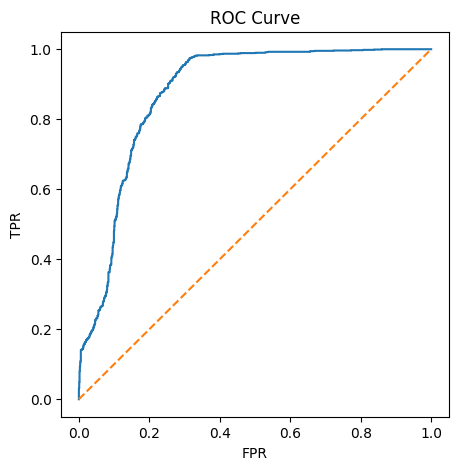

In [ ]:
# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_score)
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [ ]:
# Control del overfitting
for i in range(1,35):
    dt2 = RandomForestClassifier(max_depth=i, random_state=42, n_estimators=100)
    dt2.fit(X_train, y_train)
    acc_train = dt2.score(X_train, y_train)
    acc_test = dt2.score(X_test, y_test)
    print(f'Profundidad del arbol: {i}, Acc. train: {np.round(acc_train,3)}, Acc. test: {np.round(acc_test,3)}')

Profundidad del arbol: 1, Acc. train: 0.847, Acc. test: 0.806
Profundidad del arbol: 2, Acc. train: 0.852, Acc. test: 0.81
Profundidad del arbol: 3, Acc. train: 0.853, Acc. test: 0.812
Profundidad del arbol: 4, Acc. train: 0.856, Acc. test: 0.812
Profundidad del arbol: 5, Acc. train: 0.854, Acc. test: 0.812
Profundidad del arbol: 6, Acc. train: 0.859, Acc. test: 0.819
Profundidad del arbol: 7, Acc. train: 0.862, Acc. test: 0.824
Profundidad del arbol: 8, Acc. train: 0.864, Acc. test: 0.825
Profundidad del arbol: 9, Acc. train: 0.866, Acc. test: 0.826
Profundidad del arbol: 10, Acc. train: 0.869, Acc. test: 0.826
Profundidad del arbol: 11, Acc. train: 0.871, Acc. test: 0.828
Profundidad del arbol: 12, Acc. train: 0.874, Acc. test: 0.828
Profundidad del arbol: 13, Acc. train: 0.878, Acc. test: 0.831
Profundidad del arbol: 14, Acc. train: 0.884, Acc. test: 0.829
Profundidad del arbol: 15, Acc. train: 0.889, Acc. test: 0.829
Profundidad del arbol: 16, Acc. train: 0.896, Acc. test: 0.833
Pr

# 9. Predicción de la probabilidad de compra de emc_account para el último mes
Se realiza una predicción de la probabilidad de que cada cliente compre un emc_account en el último mes. Estos resultados se ordenan por probabilidad y se guardan en un archivo CSV.

In [ ]:
# Creamos el conjunto de datos para el último mes
last_month_df = df_grouped_emc[df_grouped_emc['pk_partition'] == last_month]

# Excluimos a los clientes que ya tienen un emc_account
last_month_df = last_month_df[last_month_df[target] == 0]

# Excluimos las ventas
X_last_month = last_month_df[features].copy()

# Normalizamos las características numéricas
X_last_month.loc[:, numeric_features] = scaler.transform(X_last_month[numeric_features])

# Hacemos las predicciones de probabilidad con el modelo
probs = model.predict_proba(X_last_month)

# Conservamos solo la probabilidad de la clase positiva
probs = probs[:, 1]

# Creamos un DataFrame para los resultados
results_emc = pd.DataFrame({
    'pk_cid': last_month_df['pk_cid'],  # reemplazar 'CustomerID' con tu columna de identificación de clientes
    'Probability_emc_account': probs
})

# Ordenamos de mayor a menor probabilidad
results_emc = results_emc.sort_values(by='Probability_emc_account', ascending=False)

# Mostramos los resultados
print(results_emc)

         pk_cid  Probability_emc_account
13690   1014691                 0.976209
328063  1412829                 0.975286
324649  1408673                 0.975286
322148  1405494                 0.973101
320164  1402562                 0.973094
...         ...                      ...
295691  1367573                 0.010734
296228  1368210                 0.010649
296209  1368188                 0.010649
296053  1368009                 0.010258
296197  1368175                 0.010061

[391005 rows x 2 columns]


In [ ]:
# Supongamos que 'pk_cid' es la columna con los identificadores de cliente
# y 'proba' es la columna con las probabilidades predichas
positive_cid1 = results_emc[results_emc['Probability_emc_account'] > 0.0]['pk_cid']

# Ahora cruza esto con tu dataframe original
cross_check1 = df[df['pk_cid'].isin(positive_cid1)]

# Verifica que todos los valores en 'pension_plan' son 0
if all(cross_check1['emc_account'] == 0):
    print("Funciona correctamente: Los resultados de probabilidad positiva tienen valor 0 en la columna!")
else:
    raise ValueError("Error en la probabilidad")

Funciona correctamente: Los resultados de probabilidad positiva tienen valor 0 en la columna!


# 10. Búsqueda de hiperparámetros óptimos
Se realiza una búsqueda aleatoria de hiperparámetros para encontrar la mejor combinación de parámetros para el modelo de Random Forest.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

## Definir el rango de parámetros para la búsqueda aleatoria
param_dist = {"max_depth": randint(10, 15),
              "n_estimators": randint(50, 100),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Crear una nueva instancia del modelo RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=50, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Ver los mejores parámetros encontrados
print("Mejores parámetros: ", random_search.best_params_)

# Utilizar el mejor modelo para hacer predicciones
best_rf = random_search.best_estimator_


Mejores parámetros:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 58}


# 11. Análisis de correlación de las variables con el target

Se realiza un análisis de correlación para identificar las variables que tienen una mayor correlación con la variable objetivo, lo que puede indicar qué variables son más importantes para la predicción.

In [ ]:
correlation_with_target = df_grouped_emc.corr()[target]
correlation_with_target = correlation_with_target.drop(target)
sorted_correlations = correlation_with_target.sort_values(ascending=False)
print(sorted_correlations)

<ipython-input-28-4d0b59373b84>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_target = df_grouped_emc.corr()[target]


segment_01 - TOP              0.305945
age                           0.285866
entry_channel_KFC             0.212836
segment_02 - PARTICULARES     0.206967
entry_channel_KAT             0.159523
                                ...   
gender_M                     -0.052462
pk_cid                       -0.090874
entry_channel_KHQ            -0.113919
entry_channel_KHE            -0.217511
segment_03 - UNIVERSITARIO   -0.284045
Name: emc_account, Length: 77, dtype: float64


In [ ]:
df_grouped_emc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444009 entries, 208903 to 444008
Data columns (total 79 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   pk_cid                      444009 non-null  int64         
 1   age                         444009 non-null  int64         
 2   salary                      444009 non-null  float64       
 3   Suma_productos_activos      444009 non-null  int64         
 4   emc_account                 444009 non-null  int64         
 5   pk_partition                444009 non-null  datetime64[ns]
 6   entry_channel_004           444009 non-null  uint8         
 7   entry_channel_007           444009 non-null  uint8         
 8   entry_channel_013           444009 non-null  uint8         
 9   entry_channel_KAA           444009 non-null  uint8         
 10  entry_channel_KAB           444009 non-null  uint8         
 11  entry_channel_KAD           444009

In [ ]:
corr = df_grouped_emc.corr()

<ipython-input-30-e285103cd40b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_grouped_emc.corr()


In [ ]:
df_grouped_emc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444009 entries, 208903 to 444008
Data columns (total 79 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   pk_cid                      444009 non-null  int64         
 1   age                         444009 non-null  int64         
 2   salary                      444009 non-null  float64       
 3   Suma_productos_activos      444009 non-null  int64         
 4   emc_account                 444009 non-null  int64         
 5   pk_partition                444009 non-null  datetime64[ns]
 6   entry_channel_004           444009 non-null  uint8         
 7   entry_channel_007           444009 non-null  uint8         
 8   entry_channel_013           444009 non-null  uint8         
 9   entry_channel_KAA           444009 non-null  uint8         
 10  entry_channel_KAB           444009 non-null  uint8         
 11  entry_channel_KAD           444009

In [ ]:
df_grouped_emc.head(1)

,pk_cid,age,salary,Suma_productos_activos,emc_account,pk_partition,entry_channel_004,entry_channel_007,entry_channel_013,entry_channel_KAA,...,entry_channel_KHS,entry_channel_No_data,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_no_indica,gender_H,gender_M,gender_no_data
208903,1262610,36,90387.0,1,1,2018-01-01,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
corr.style.background_gradient(cmap='coolwarm')

# 12. Descargamos el archivo con la propabilidad por cliente

In [ ]:
from google.colab import files

# Guardar el dataframe en un archivo CSV
results_emc.to_csv('results_emc.csv', index=False)

# Descargar el archivo CSV
files.download('results_emc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>